In [1]:
import torch

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2

In [3]:
class_name = [
      '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
      'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
      'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
      'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
      'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
      'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
      'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
      'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
      'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
      'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
      'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
      'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
      'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [4]:
class_name[74]

'book'

In [5]:
import sys

In [6]:
sys.argv = ['-f', 'fewdet', '--exp_id', 'coco_dla','--num_workers', '0','--batch_size','1', '--dataset','coco'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [1]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\fewdet\coco_dla
fewdet
0
1


In [7]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [8]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'ss': 80, 'hm': 1, 'wh': 2, 'reg': 2}


In [9]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

In [10]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [11]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=False,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=15.14s)
creating index...
index created!
Loaded train 118287 samples


In [12]:
img = next(iter(train_loader))

In [13]:
img['hm'][0][0,34,102]

IndexError: too many indices for tensor of dimension 2

In [ ]:
(img['hm'][0] == 1).nonzero(as_tuple=False)

In [ ]:
(img['ss'][0] == 1).nonzero(as_tuple=False)

In [ ]:
img['hm'][0][62,73]

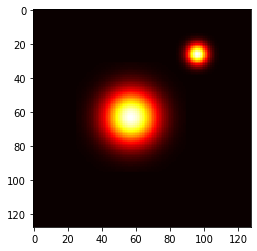

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img['hm'][0], cmap='hot', interpolation='nearest')

In [17]:
#img = next(iter(train_loader))
img_og = cv2.imread(img['img_path'][0])
img_og = cv2.cvtColor(img_og, cv2.COLOR_BGR2RGB)
plt.imshow(img_og)

KeyError: 'img_path'

In [19]:
img['img_path'][0] #lib\\..\\..\\data\\coco\\train2017\\000000024030.jpg'
num_objs = img['num_objs'][0]
ann_ids = img['ann_ids'][0]
anns = img['anns'][0]

In [15]:
img['img_path'][0]

'C:\\Users\\avata\\FewShot-CenterNet\\src\\lib\\..\\..\\data\\coco\\train2017\\000000024030.jpg'

In [54]:
Dataset(opt,'train')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=17.62s)
creating index...
index created!
Loaded train 118287 samples


<datasets.dataset_factory.get_dataset.<locals>.Dataset at 0x2cba2d0c988>

In [15]:
Dataset.__getitem__(opt, 0)

AttributeError: 'Namespace' object has no attribute 'images'

In [69]:
Dataset.__getitem__(opt,'C:\\Users\\avata\\FewShot-CenterNet\\src\\lib\\..\\..\\data\\coco\\train2017\\000000024030.jpg')

AttributeError: 'Namespace' object has no attribute 'images'

In [40]:
ann_ids

tensor([99117])

In [24]:
num_objs

tensor(18)

In [28]:
opt.debug 

0

In [14]:
import torch.utils.data as data
import numpy as np
import torch
import json
import cv2
import os
from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg
import math